# Actor-Critic

This Notebook reimplements an Actor-Critic agent in Pytorch with GPU acceleration and trains it to play Pong.

We basically takes PyTorch's Actor-critic implementation for Cartpole as the starter code, and adapt it to play Pong. The end result is an agent built on PyTorch which barely beats the game AI (running reward of 1.0), significantly underperforming Karpathy's implementation.

This basic explore-exploit problem can be solved using temperature in the softmax classifier, and this is the basis of our single agent Actor-Critic implementation in another folder:

https://github.com/LUKELIEM/actor-critic

This new actor-critic implementation greatly exceeds Karpathy's REINFORCE performance in much fewer number of training episodes.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import random
import torch
import pickle as pickle
import pympler
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


## Implement Actor-Critic in PyTorch with GPU Acceleration

We implement the ACTOR-CRITIC-Pong in PyTorch:
 
(1) We address the GPU memory error problem by limiting the number of game steps per episode and by emptying the torch's cuda cache after each backprop.  
(2) The algorithm's performance using RmsProp at lr = 1e-3 flattens at 1.0

```
Batch 30000	Last Reward: -4.00	Running Reward: 0.68
Time taken: -43185.0356965065
```

The code is based on PyTorch's example for Actor-Critic which masters the simple game of Cartpole: 
https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py


In [ ]:
import argparse
import gym
import time
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
render=False
verbose=False  # To step through the code and understand what is going on
log_interval=10
batch_size = 1200  # Start out with 1200 games steps before actor and critic parameter update


env = gym.make("Pong-v0")

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 512 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 512)
        self.action_head = nn.Linear(512, 2)
        self.value_head = nn.Linear(512, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of a batch of 
    game steps. This is necessary to prevent GPU memory error.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is Q(s,a)

    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]).type(gpu_dtype))))

        
    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]



# Main loop
lr_rates = [1e-3]

for learning_rate in lr_rates:
    
    running_reward = -21
    
    actorCritic=[]
    
    # Call an instance of the Policy and select ADAM as update rule
    model = Policy().cuda()
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.01)  # RMSProp instead of ADAM
    start = time.time()
    
    print ("Learning Rate = ", learning_rate)

    # for i_episode in count(1):  # Infinite loop
    for i_episode in range(30001): # just run 30000 episode 
        state = env.reset()
        reward_sum = 0
        prev_x = None
        done = False
    
        for t in range(batch_size):

            # Downsample 210x160x3 frame into 1600 (40x40) 1D float vector
            cur_x = process_frame40(state)
            state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
            prev_x = cur_x

            # Sample an action from Policy based on state provided by env
            action = select_action(state)
        
            # step env through the sampled action
            state, reward, done, _ = env.step(action)
            reward_sum += reward
        
            if render:
                env.render()
            
            # append reward to policy.reward[]
            # this is needed to calculate policy gradient at the end of the episode  
            model.rewards.append(reward)
        
            # break if episode is done even if it has not reached batch size
            if done:
                break
            
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
        # Calculate policy gradient and update Policy 
        finish_batch()
        gc.collect()  # clean up some garbage
        torch.cuda.empty_cache()  # Release GPU memory
    
        actorCritic.append([reward_sum, running_reward])

        # print out and show sign of life
        if i_episode % log_interval == 0:
            print('Batch {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                    i_episode, reward_sum, running_reward))
    
        # track memory usage every 2000 episodes
        if i_episode % 2000 == 0:
            # summary.print_(summary.summarize(muppy.get_objects()))  # track memory usage
            file_name = './results/actor-critic/pong_'+'lr='+str('{:.2e}'.format(learning_rate)) \
                        +'ep='+str(i_episode)+'model.pt'
            torch.save(model.state_dict(), file_name)
        
end = time.time()
print ("Time taken:", start-end)     
env.close()

history_file = './results/actor-critic/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(actorCritic, open(history_file, 'wb'))

In [26]:
file_name = './results/actor-critic/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(actorCritic, open(file_name, 'wb'))

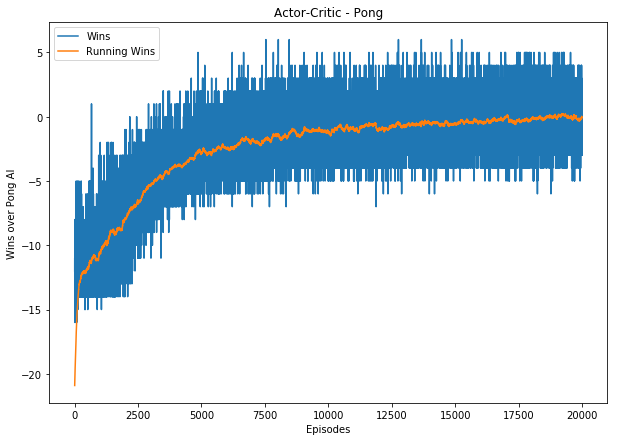

In [3]:
data = pickle.load(open('./results/actor-critic/pong_ep=20000history.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('Actor-Critic - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

## Load Parameters and Let's Play

The code below loads parameters from saved model into the actor-critic agent and renders 1 episode. The agent and the game will play til one of them reach 21 points.

In [2]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
verbose=False  # To step through the code and understand what is going on

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 512 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 512)
        self.action_head = nn.Linear(512, 2)
        self.value_head = nn.Linear(512, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(cpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    return action.data[0]+2  # UP=2, DOWN=3


# Call an instance of the Policy and load it with a parameter file
model = Policy()
# file_name='./results/actor-critic/pong_ep=18000model.pt'
file_name='./results/actor-critic/pong_lr=1.00e-03ep=18000model.pt'
model.load_state_dict(torch.load(file_name, map_location=lambda storage, loc:storage))
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

env = gym.make("Pong-v0")
state = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 10000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = process_frame40(state)
  state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
  prev_x = cur_x

  # Sample an action from Policy based on state provided by env
  action = select_action(state)
        
  # step env through the sampled action
  state, reward, done, _ = env.step(action)
  reward_sum += reward
        
env.close()
print (reward_sum)

5.0
